Ensemble Classifiers:
Random Forests
AdaBoost

Created: 4/13/2020
Last Modified: 4/13/2020
Author: Sarah Mounho

In [1]:
#Library Imports
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
C:\Users\sarah\Anaconda3\envs\CS329E_Project\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
#import clean data
from utils import intake_data
data = intake_data()
data.isnull().sum(axis = 0)
data_X = data.iloc[:, :16]
data_Y = data.iloc[:, 17] #df with class labels


**Class Balance**  
There is a class imbalance in the data, death = 1 (n=69) death = 0 (n=128). To even out the class imblance, SMOTE will be used to create new death = 1 data points.

In [3]:
#Balance classes
from imblearn import over_sampling
oversample = over_sampling.SMOTE()
X_SMOTE, Y_SMOTE = oversample.fit_resample(data_X, data_Y)
print(X_SMOTE.shape)
Y_SMOTE.value_counts()
X_SMOTE.head(10)

(256, 16)


,age,sex,Alb,PLT,WBC,CRP,APACHE II,SOFA,McCabe,PaO2/FiO2,LDH,CT score,PEEP,PIP,TV,DARDS = 1
0,79.0,0,2.3,10.8,4000.0,17.8,24.0,8.0,1.0,108.0,339.0,191.6,24.0,25.948052,428.05036,0.0
1,83.0,0,4.4,13.5,10200.0,8.9,16.0,6.0,1.0,78.0,385.0,213.3,5.0,10.000000,360.00000,0.0
2,70.0,0,2.7,10.8,5300.0,25.3,22.0,7.0,1.0,70.9,461.0,221.7,18.0,24.000000,525.00000,0.0
3,61.0,0,3.3,8.8,1800.0,22.2,26.0,7.0,1.0,59.2,227.0,211.6,10.0,24.000000,480.00000,0.0
4,81.0,0,3.1,26.2,10600.0,17.0,19.0,4.0,1.0,83.6,680.0,234.9,5.0,10.000000,625.00000,0.0
5,79.0,0,3.4,37.9,13200.0,21.0,18.0,5.0,1.0,71.5,224.0,236.7,5.0,25.000000,460.00000,0.0
6,83.0,0,2.8,18.0,1500.0,54.9,30.0,11.0,1.0,96.2,342.0,180.5,22.0,25.948052,428.05036,0.0
7,70.0,0,2.8,18.5,14100.0,18.4,15.0,5.0,1.0,78.2,478.0,311.6,10.0,25.000000,428.05036,0.0
8,65.0,1,3.2,35.4,7200.0,10.4,18.0,3.0,1.0,194.0,316.0,231.6,8.0,23.000000,440.00000,0.0
9,72.0,0,2.9,26.8,19800.0,29.4,20.0,5.0,1.0,74.0,245.0,233.1,5.0,25.000000,428.05036,0.0


###### Random Forest Classifier 
Random Forests are an extension of bagged decision trees. They randomly select a subset of the input features for candidate splits to test. The feature with the best gain is selected from the subset. This process is repeated many times. The class label is then decided based on the most frequent classification from the trees. The samples are drawn with replacement.   

***Hyperparameters:***  
  
*max_depth*- The maximumm depth of the tree. The range of values tested for max_depth are: [1, 10, 20, 30, 40, 50]  
  
*min_samples_leaf*- The minimum number of samples required to be a leaf node. The tree will not be split if less than min_samples_leaf is left in either the left or right branch. The range of values tested for min_samples_leafe are: [1, 2,  3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15].  
  
*max_features*- The number of features to consider when looking for the best split. Consider sqrt(n_features) and log2(n_features).  
  


              precision    recall  f1-score   support

           0       0.71      0.64      0.67       128
           1       0.67      0.74      0.71       128

    accuracy                           0.69       256
   macro avg       0.69      0.69      0.69       256
weighted avg       0.69      0.69      0.69       256

AUC score: 0.691


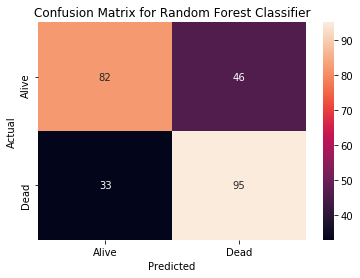

In [5]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sn
#Create a random forest classifier
rfc = RFC()
#params 
max_depth_lst = list(range(1, 51, 9))
min_leaf_lst = list(range(1, 15))
param_grid = {'max_depth': max_depth_lst,
              'min_samples_leaf': min_leaf_lst,
              'max_features': ['sqrt', 'log2']    
}
#grid search for best max depth, min samples per leaf and max features
clf = GridSearchCV(rfc, param_grid, cv=5)
#cross validation
Y_pred = cross_val_predict(clf, X_SMOTE, Y_SMOTE, cv=5)
#Report
print(classification_report(Y_SMOTE, Y_pred, labels=[0, 1]))

#ROC curve
fpr, tpr, thresholds = roc_curve(Y_SMOTE, Y_pred, pos_label=1)
roc_score = roc_auc_score(Y_SMOTE, Y_pred)
print('AUC score:', round(roc_score, 3))

#Create a confusion matrix
data = {'Actual': Y_SMOTE, 'Predicted':Y_pred}
df = pd.DataFrame(data, columns=['Actual', 'Predicted'])
df['Predicted'].replace(0, 'Alive', inplace=True)
df['Predicted'].replace(1, 'Dead', inplace=True)
df['Actual'].replace(0, 'Alive', inplace=True)
df['Actual'].replace(1, 'Dead', inplace=True)
cm = pd.crosstab(df['Actual'], df['Predicted'], rownames=['Actual'], colnames=['Predicted'])                                    
#Print a formatted confusion matrix using a heatmap
sn.heatmap(cm, annot=True)
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

###### Boosting
  
AdaBoostClassifier is an ensemble classifier that iteratively changes the distribution of the training data. The base classifiers focus on hard to classify examples by assigning a weight to each example and updating that weight at the end of each boosting rund. The weight is then used as a sampling dsitribution to draw a set of bootstrap samples. The base estimator is a DecisionTreeClassifier(max_depth=1).  
  
***Hyperparameters:***  
  
*number of estimators*- The maximum number of estimators before the boosting is terminated.

              precision    recall  f1-score   support

           0       0.67      0.63      0.65       128
           1       0.65      0.69      0.67       128

    accuracy                           0.66       256
   macro avg       0.66      0.66      0.66       256
weighted avg       0.66      0.66      0.66       256

AUC score: 0.66


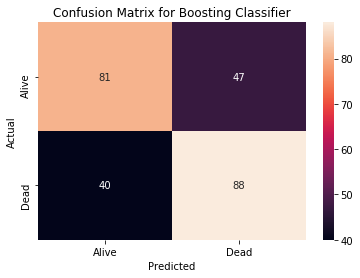

In [6]:
from sklearn.ensemble import AdaBoostClassifier as ABC
#create an AdaBoostClassifier
abc = ABC()
#params
est_lst = list(range(5, 200, 5))
param_grid = {'n_estimators': est_lst}
#grid search for best n_estimators
clf = GridSearchCV(abc, param_grid, cv=5)
#cross validation
Y_pred = cross_val_predict(clf, X_SMOTE, Y_SMOTE, cv=5)
#Report
print(classification_report(Y_SMOTE, Y_pred, labels=[0, 1]))

#ROC curve
fpr, tpr, thresholds = roc_curve(Y_SMOTE, Y_pred, pos_label=1)
roc_score = roc_auc_score(Y_SMOTE, Y_pred)
print('AUC score:', round(roc_score, 3))

#Create a confusion matrix
data = {'Actual': Y_SMOTE, 'Predicted':Y_pred}
df = pd.DataFrame(data, columns=['Actual', 'Predicted'])
df['Predicted'].replace(0, 'Alive', inplace=True)
df['Predicted'].replace(1, 'Dead', inplace=True)
df['Actual'].replace(0, 'Alive', inplace=True)
df['Actual'].replace(1, 'Dead', inplace=True)
cm = pd.crosstab(df['Actual'], df['Predicted'],
                 rownames=['Actual'], colnames=['Predicted'])                                    
#Print a formatted confusion matrix using a heatmap
sn.heatmap(cm, annot=True)
plt.title('Confusion Matrix for Boosting Classifier')
plt.show()
